In [1]:
using Flux, DataFrames, CSV, ProgressMeter, DiffEqFlux, LinearAlgebra, DifferentialEquations, Plots

In [65]:
data =
    CSV.File(
        joinpath(pwd(), "..", "..", "..", "data", "measures.csv");
        typemap = Dict(Float64 => Float32),
    ) |> DataFrame
@. data[!, :i_norm] = sqrt(data.i_d^2 + data.i_q^2);


In [66]:
target_cols = ["pm", "stator_tooth", "stator_winding", "stator_yoke"]
gdf = groupby(data, :profile_id)

# just work on profile 60 for now (dummy)
p6 = get(gdf, (profile_id = 60,), nothing);

In [73]:
p6[:, input_cols] ./= Array(combine(p6[:, input_cols], input_cols .=> maximum))

,u_q,u_d,motor_speed,i_d,i_q,torque,i_norm
,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,-0.0121596,0.0140862,0.000132927,0.00840082,0.00378455,-1.10349e-16,0.00691178
2,0.0138671,0.0226707,0.013326,0.0189498,-0.0522111,-0.0484478,0.0478336
3,0.0464424,0.0375936,0.0304127,0.0294408,-0.104036,-0.0934855,0.0937745
4,0.0931541,0.0563284,0.0537113,0.0352623,-0.133848,-0.11925,0.120233
5,0.152966,0.0725785,0.0824535,0.0355195,-0.14124,-0.125383,0.126621
6,0.22238,0.0868279,0.115061,0.032269,-0.138642,-0.122769,0.123925
7,0.285331,0.0989481,0.144617,0.0287385,-0.134232,-0.118646,0.119657
8,0.341669,0.11297,0.171397,0.027248,-0.133282,-0.117631,0.118653
9,0.397096,0.135297,0.198887,0.0291045,-0.139021,-0.122592,0.123845


In [75]:
describe(p6)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Abstrac…,Real,Float64,Real,Int64,DataType
1,u_q,0.44093,-0.0218687,0.442735,1.0,0,Float32
2,coolant,50.6554,19.6354,46.1208,92.966,0,Float32
3,stator_winding,75.318,29.6719,69.8106,129.001,0,Float32
4,u_d,0.0308385,-1.00211,0.00585408,1.0,0,Float32
5,stator_tooth,66.6693,28.8839,61.5162,104.791,0,Float32
6,motor_speed,0.380563,-2.32541e-6,0.386978,1.0,0,Float32
7,i_d,0.273162,0.00838749,0.23913,1.0,0,Float32
8,i_q,-0.0690173,-0.993894,0.00378328,1.0,0,Float32
9,pm,64.7335,35.5059,63.8682,85.1463,0,Float32


In [63]:
n_temps = 6

arranged_p6 = Array(p6[:, [target_cols; ["ambient", "coolant"]]]) ./ 100
input_cols =
    [c for c in names(p6) if c ∉ [target_cols; ["ambient", "coolant", "profile_id"]]]


# populate adjacency matrix
function get_adj_mat(n_temps_)
    adj_mat = zeros(Int8, n_temps_, n_temps_)
    k = 1
    for col_j = 1:n_temps_
        for row_i = col_j+1:n_temps_
            adj_mat[row_i, col_j] = k
            k += 1
        end
    end
    adj_mat = adj_mat + adj_mat'
end

n_conds = Int(0.5 * n_temps * (n_temps - 1))

adj_mat = get_adj_mat(n_temps)


i_norm = Array(p6.i_norm) ./ maximum(p6.i_norm)
function lptn_1d!(du, u, p, t)
    ex_idx = clamp(Int(round(t)), 1, nrow(p6))
    conductances, loss_p, caps = p
    current_temps = arranged_p6[ex_idx, :]
    temp_diffs = [
        sum(
            current_temps[j] - u[i] * conductances[adj_mat[i, j]] for
            j in 1:n_temps if j != i
        ) for i = 1:size(target_cols, 1)
    ]
    du[:] .= caps .* (i_norm[ex_idx] .* loss_p .+ temp_diffs)

end

# Initial condition
u0 = Array(p6[1, target_cols]) ./ 100

# Simulation interval and intermediary points
tspan = (0.0, nrow(p6) - 1)
tsteps = 0:nrow(p6)-1

# LV equation parameter. p = [conductances, loss_factors, inverse_capacitances]
p = [
    abs.(randn(n_conds)),
    abs.(randn(size(target_cols, 1))),
    10 .^ (-1 .- 2 .* rand(Float64, size(target_cols, 1))),
]


dudt = FastChain(
    (x, p) -> x,
    FastDense(length(target_cols), 8, tanh),
    FastDense(8, length(target_cols)),
)

conductance_net = FastChain((x, p) -> x, FastDense(length(input_cols), n_conds, σ))
conductance_net_psize = DiffEqFlux.paramlength(conductance_net)

ploss_net = FastChain(
    (x, p) -> x,
    FastDense(length(input_cols), 8, tanh),
    FastDense(8, length(target_cols)),
)
ploss_net_psize = DiffEqFlux.paramlength(ploss_net)

sample_time = 0.5

function tnn!(dx, x, p, t)
    ex_idx = clamp(Int(round(t)), 1, nrow(p6))
    #conductance_net_params, loss_net_params, caps_params = p
    conductance_net_params = p[begin:conductance_net_psize]
    loss_net_params = p[conductance_net_psize+1:conductance_net_psize+ploss_net_psize]
    caps_params = p[conductance_net_psize+ploss_net_psize+1:end]
    conductances = conductance_net(Array(p6[ex_idx, input_cols]), conductance_net_params)
    loss_p = ploss_net(Array(p6[ex_idx, input_cols]), loss_net_params)
    current_temps = [x; Array(p6[ex_idx, ["ambient", "coolant"]])]


    #temp_diffs = [
    #    sum(current_temps[j] - x[i] * conductances[1] #adj_mat[i, j]]
    #        for j in 1:n_temps if j != i) for i = 1:size(target_cols, 1)
    #]
    
    temp_diffs = zeros(eltype(caps_params), size(caps_params))
    @inbounds @simd for i in 1:size(target_cols, 1)
        @inbounds @simd for j in 1:n_temps
            if j != i
                # nightmarish workaround to avoid indexing with i, j
                #  since that is apparently not differentiable
                if j > i
                    cond_idx = (i-1)*(n_temps-i) + j - 1 + i ÷ 2 + 2*(i ÷ 3)
                else
                    cond_idx = (j-1)*(n_temps-j) + i - 1 + j÷2 + 2*(j ÷ 3)
                end
                @. temp_diffs += (current_temps[j] - x[i]) * conductances[cond_idx]
            end
        end
    end

    dx[:] .= 10 .^ caps_params .* sample_time .* (loss_p .+ temp_diffs)
end


prob_neuralode = ODEProblem(
    tnn!,
    u0,
    tspan,
    [
        initial_params(conductance_net),
        initial_params(ploss_net),
        (-1 .- 2 .* rand(Float32, size(target_cols, 1))),
    ],
)

function predict_neuralode(p)
    tmp_prob = remake(prob_neuralode; p = p)
    Array(solve(
        tmp_prob,
        Tsit5(), #sensealg=ReverseDiffAdjoint(), 
        saveat = tsteps,
    ))
end

scaled_targets = Array(p6[!, target_cols]) ./ 100

function loss_neuralode(p)
    pred = predict_neuralode(p)
    #println(size(scaled_targets), size(pred))
    loss = sum(abs2, scaled_targets .- pred') # Just sum of squared error
    return loss, pred
end

plot_cb = function (p, l, pred; doplot = true)
    display(l)
    # plot current prediction against data
    plt = plot(tsteps, scaled_targets, label = "data")
    plot!(plt, tsteps, pred', label = "prediction")
    annotate!(0.5, 2, text(l, :left, 10))
    if doplot
        display(plt)
    end

    return false
end


result_neuralode =
    DiffEqFlux.sciml_train(loss_neuralode, reduce(vcat, prob_neuralode.p), cb = plot_cb)


# Setup the ODE problem, then solve
#prob = ODEProblem(lptn_1d!, u0, tspan, p)
#sol = solve(prob)


1.486351f8

LoadError: Expects 14543 elements in each col of y, found 4.

In [ ]:
using Zygote
f(A::AbstractArray) = first(loss_neuralode(A))
Zygote.gradient(f, reduce(vcat, prob_neuralode.p))

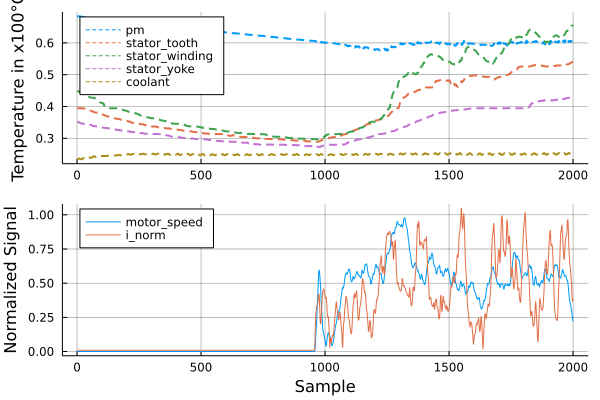

In [ ]:
# plot excitation jump and consequences in temperature trajectories (zoom-in)
coi = [target_cols..., "coolant", "motor_speed", "i_norm"]
dfui = p6[8000:10000, coi]
dfui[!, :motor_speed] /= 6000
dfui[!, :i_norm] /= 250
p1 = plot(
    Array(dfui[!, [target_cols..., "coolant"]]) ./ 100,
    lab = reshape(vec([target_cols..., "coolant"]), (1, :)),
    line = (2, reshape([:dash, :dash, :dash, :dash, :dash], 1, :)),
    
    yaxis = "Temperature in x100°C",
    gridalpha = 0.5,
)
p2 = plot(
    Array(dfui[!, ["motor_speed", "i_norm"]]),
    lab = reshape(vec(["motor_speed", "i_norm"]), (1, :)),
    xaxis = "Sample",
    yaxis = "Normalized Signal",
    gridalpha=0.5
)
plot(p1, p2, layout = (2, 1), legend= :topleft)
#plot!(sol)




In [ ]:
plot(
    Array(p6[!, target_cols] ./ 100),
    lab = reshape(vec(target_cols), (1, :)),
    yaxis = "Temperature in x100°C", line=(3, :dash),
    gridalpha = 0.5, alpha=0.5
)
plot!(sol, lab=reshape(vec([t *"_pred" for t in target_cols]), (1, :)))


In [ ]:
plot(sol, vars=(1,2,3,4))

LoadError: UndefVarError: sol not defined

In [ ]:
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2], length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))

dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
dudt!(u, p, t) = dudt2(u, p)
u0 = rand(2)
prob_neuralode = ODEProblem(dudt!, u0, tspan, initial_params(dudt2))
sol_node = solve(prob_neuralode, Tsit5(), saveat = tsteps)

function predict_neuralode(p)
  tmp_prob = remake(prob_neuralode, p = p)
  Array(solve(tmp_prob, Tsit5(), saveat = tsteps))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

callback = function (p, l, pred; doplot = true)
  #display(l)
  # plot current prediction against data
  plt = scatter(tsteps, ode_data[1,:], label = "data")
  scatter!(plt, tsteps, pred[1,:], label = "prediction")
  annotate!(0.5, 2, text(l, :left, 10))
  if doplot
    display(plt)
  end
  return false
end

result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p, cb = callback)